# Intro

https://www.kaggle.com/c/learn-together

My attempt at the contest, upvoted kernels, which I found useful.

**Resources**

* [How to add table of contents](https://www.kaggle.com/questions-and-answers/69732)
* [Hyperparameter Tuning](https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624)
* [Stacking: Improve model performance](https://dkopczyk.quantee.co.uk/stacking/)

# Versioning

* Version: 5.0
* Steps: 
  - Feature importance visualization
  - MLXtend stacking, with layer one models below and RandomForest stacking model
    - LightGBM
    - LogisticRegression
    - KNeighborsClassifier
  - Hyperparameter optimization for layer one using grid search
  - For identifying stack model and validation, using X_train, y_train; For df_test fitting on X, Y

# Table of contents <a id="0"></a>
* [Imports](#imports)
* [Block selection](#block-selection)
* [Define models](#define-models)
* [Identify important Features](#identify-important-features)
* [Feature engineering](#feature-engineering)
* [Separate features and target](#separate-features-and-target)
* [Get initial scores](#get-initial-scores)
* [Grid search](#grid-search)
* [Generate output](#generate-output)

In [1]:
import os
dir = !ls -a
if ('kernel-metadata.json' in dir):
    src = 'Local'
    # Local environment
    data_path = './data/learn-together'
else:
    # Kaggle environment
    src = 'Kaggle'
    data_path = '../input/learn-together'

print('Environment set to [{env}]'.format(env=src))
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Environment set to [Kaggle]
../input/learn-together/train.csv
../input/learn-together/sample_submission.csv
../input/learn-together/test.csv


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/learn-together/train.csv
/kaggle/input/learn-together/sample_submission.csv
/kaggle/input/learn-together/test.csv


In [3]:
# Suppress future defaults warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# System imports
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Utilities
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from mlxtend.classifier import StackingCVClassifier

In [4]:
df_test = pd.read_csv(data_path + '/test.csv')
df_sample_submission = pd.read_csv(data_path + '/sample_submission.csv')
df = pd.read_csv(data_path + '/train.csv')

In [5]:
# Separate features and target
target = 'Cover_Type'
features = list(df.columns)
features.remove(target)

X = df[features]
y = df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, train_size=0.8)

# Block selection <a id="block-selection"></a>
[Go back to top](#0)

In [6]:
evaluate_model_combinations = 0
get_feature_importances = 1
drop_low_correlation_features = 0
drop_singular_columns = 1
grid_search = 0
validation = 0
generate_output = 1
get_initial_scores = 0

low_correlation_features = []
grid_search_n_splits = 5
layer_one_folds = 5

# Define models <a id="define-models"></a>
[Go back to top](#0)

In [7]:
# Define Base (level 0) and Stacking (level 1) estimators
# Commented rows were during Hyperparameter optimization run
base_models = []

lgbm_clf = {}
lgbm_clf['model'] = LGBMClassifier(num_leaves=128, verbose=-1, random_state=5, n_jobs=1)
lgbm_clf['params'] = {'n_estimators': [100, 200, 300, 400]}
lgbm_clf['grid_search'] = 0
base_models.append(lgbm_clf)

etc_clf = {}
etc_clf['model'] = ExtraTreesClassifier(n_estimators=300, min_samples_leaf=2, min_samples_split=2, max_depth=50
                               , random_state=5, n_jobs=1)
etc_clf['params'] = {'n_estimators': [200, 300, 400, 500]}
etc_clf['grid_search'] = 0
base_models.append(etc_clf)

adb_clf = {}
adb_clf['model'] = AdaBoostClassifier(n_estimators=200, random_state=5)
adb_clf['params'] = {'n_estimators': [100, 150, 200, 400]}
adb_clf['grid_search'] = 0
base_models.append(adb_clf)

svc_clf = {}
svc_clf['model'] = SVC(probability=True, random_state=5, gamma='scale')
svc_clf['params'] = {'C': [0.01, 0.1, 1, 10, 100]}
svc_clf['grid_search'] = 0
base_models.append(svc_clf)

xgb_clf = {}
xgb_clf['model'] = XGBClassifier(random_state=5)
xgb_clf['params'] = {}
xgb_clf['grid_search'] = 0
base_models.append(xgb_clf)

rf_clf = {}
rf_clf['model'] = RandomForestClassifier(n_estimators=400, random_state = 5)
rf_clf['params'] = {'n_estimators': [200, 300, 400]}
rf_clf['grid_search'] = 0
base_models.append(rf_clf)

knn_clf = {}
knn_clf['model'] = KNeighborsClassifier()
knn_clf['params'] = {'n_neighbors': range(3,12,2), 'weights': ['uniform', 'distance']}
knn_clf['grid_search'] = 0
base_models.append(knn_clf)

lr_clf = {}
lr_clf['model'] = LogisticRegression(random_state=5)
lr_clf['params'] = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
lr_clf['grid_search'] = 0
base_models.append(lr_clf)

# Define Stacking estimator
rf_stk = {}
rf_stk['model'] = RandomForestClassifier(n_estimators=300, random_state=5)
rf_stk['grid_search'] = 0
rf_stk['name'] = rf_stk['model'].__class__.__name__

for base_model in base_models:
    base_model['name'] = base_model['model'].__class__.__name__ 

In [8]:
def get_stacked_model(models, stack_model, X, y, splits):
    stack = StackingCVClassifier(classifiers=models,
                             meta_classifier=stack_model,
                             cv=splits,
                             stratify=True,
                             shuffle=True,
                             use_probas=True,
                             use_features_in_secondary=True,
                             verbose=0,
                             random_state=5,
                             n_jobs=2)

    stack = stack.fit(X, y)
    stack_out = copy.deepcopy(stack)
    return stack_out

In [9]:
model_combinations = []
model_combinations_score = []

# 3 models
# Models: [['LGBMClassifier', 'KNeighborsClassifier', 'LogisticRegression']]
# Score: [0.9014550264550265]

# 7 models
# Models: [['LGBMClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'SVC', 'XGBClassifier', 'RandomForestClassifier', 'KNeighborsClassifier']]
# Score: [0.8991402116402116]

# 6 models
# Models: [['LGBMClassifier', 'AdaBoostClassifier', 'SVC', 'XGBClassifier', 'RandomForestClassifier', 'KNeighborsClassifier']]
# Score: [0.8961640211640212]
    
# 8 models
# Models: [['LGBMClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'SVC', 'XGBClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'LogisticRegression']]
# Score: [0.8912037037037037]

# 4 models
# Models: [['XGBClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'LogisticRegression']]
# Score: [0.8895502645502645]

# 5 models
# Models: [['LGBMClassifier', 'AdaBoostClassifier', 'SVC', 'RandomForestClassifier', 'KNeighborsClassifier']]
# Score: [0.8875661375661376]
    
#for r in range(3, 3):#len(base_models)):
combs = itertools.combinations(base_models, 8)
for comb in combs:
    model_combinations.append(comb)

if evaluate_model_combinations:
    for model_combination in model_combinations:
        models = [copy.deepcopy(model['model']) for model in model_combination]
        model_names = [model['name'] for model in model_combination]
        stack_fitted = get_stacked_model(models, stack_model['model'], X_train, y_train, layer_one_folds)
        pred = stack_fitted.predict(X_val)
        score = accuracy_score(y_val, pred)
        model_combination_score = {'models': models, 
                                   'model_names': model_names, 
                                   'score': score}
        model_combinations_score.append(model_combination_score)
        #print(model_combinations_score)
        
    for model_combinations_score in sorted(model_combinations_score, key=lambda x: x['score'], reverse=True):
        print('Models: [{models}]\nScore: [{score}]'
              .format(models=model_combinations_score['model_names']
                      , score=model_combinations_score['score']))   

else:
    model_combination_score = {'models': [lgbm_clf, knn_clf, lr_clf], 
                               'model_names': ['LGBMClassifier', 'KNeighborsClassifier', 'LogisticRegression'], 
                               'score': 0.9014550264550265}

# Identify important features <a id="identify-important-features"></a>
[Go back to top](#0)

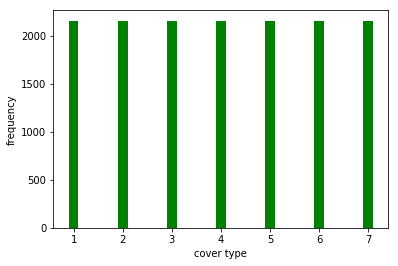

In [10]:
# Check if target types are evenly spread
plt.ylabel('frequency')
plt.xlabel('cover type')
plt.bar(df['Cover_Type'].unique(), df['Cover_Type'].value_counts(), color ='green', width=0.2)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

# Evenly distributed, that's great**

In [11]:
# Print numerical values of important features
if get_feature_importances:
    target = 'Cover_Type'
    features = list(df.columns)
    features.remove(target)

    X = df[features]
    y = df[target]

    bestfeatures = SelectKBest(k=10)
    fit = bestfeatures.fit(X, y)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score'] 
    print(featureScores.nlargest(20,'Score'))

                                 Specs         Score
1                            Elevation  16241.233317
14                    Wilderness_Area4   5072.497908
6      Horizontal_Distance_To_Roadways   1223.070458
24                         Soil_Type10    977.737621
17                          Soil_Type3    929.217593
11                    Wilderness_Area1    928.831132
10  Horizontal_Distance_To_Fire_Points    746.124576
52                         Soil_Type38    744.906554
53                         Soil_Type39    640.529899
13                    Wilderness_Area3    444.959975
54                         Soil_Type40    422.043458
7                        Hillshade_9am    378.220751
4     Horizontal_Distance_To_Hydrology    375.897228
44                         Soil_Type30    352.446574
43                         Soil_Type29    341.825668
3                                Slope    301.849051
18                          Soil_Type4    248.325587
36                         Soil_Type22    233.

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [21 29] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[6.06078820e-02 1.67811839e-01 4.66352936e-02 3.76217869e-02
 5.07028456e-02 4.53416261e-02 6.65798778e-02 4.50555136e-02
 4.28213178e-02 4.10463985e-02 6.33196151e-02 1.67065600e-02
 3.09349544e-03 1.16645779e-02 6.91454992e-02 1.95407964e-03
 7.40469321e-03 2.10121104e-02 1.52876263e-02 1.73095764e-03
 2.67306464e-03 0.00000000e+00 2.10491130e-05 1.73704545e-04
 2.55402509e-02 4.11776948e-03 5.87850471e-03 8.16594452e-03
 2.32463597e-03 0.00000000e+00 1.47593055e-03 1.02669411e-02
 1.03846528e-03 7.94341426e-04 2.38192801e-03 2.45540111e-04
 7.90806013e-03 7.76980677e-03 3.53780050e-03 3.50025013e-05
 7.40621185e-04 2.11002139e-04 1.86676671e-04 5.58306911e-03
 8.56153225e-03 3.07933572e-03 5.82248227e-03 3.88861645e-03
 5.83309742e-04 4.21819583e-03 2.78495092e-04 1.21610236e-03
 2.76397305e-02 2.60320837e-02 1.20664108e-02]


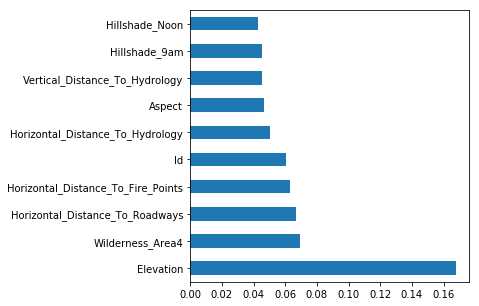

In [12]:
# plot graph of feature importances for better visualization
if get_feature_importances:
    model = ExtraTreesClassifier()
    model.fit(X,y)
    print(model.feature_importances_) 
    
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

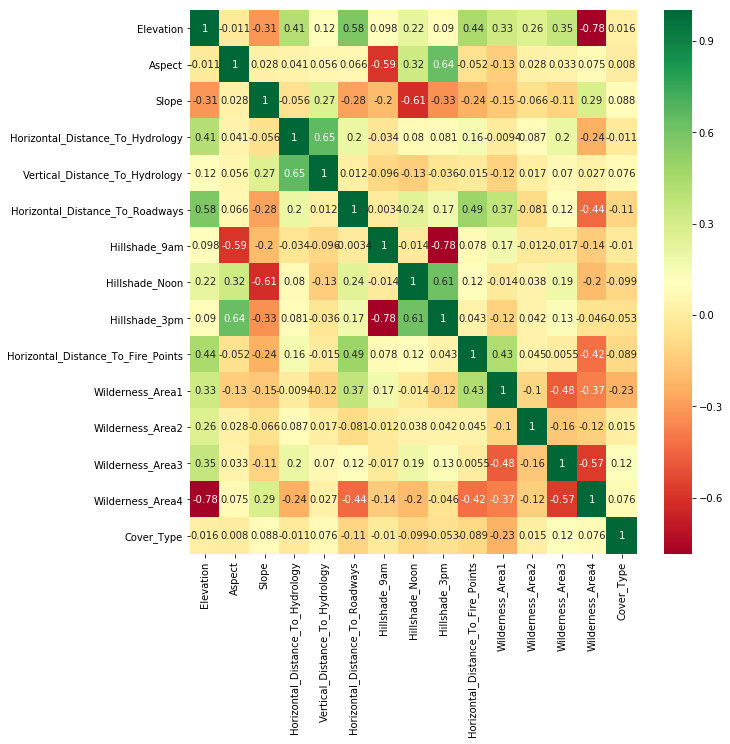

In [13]:
# Generate heatmap
if get_feature_importances:
    # Only considering non-categorical columns for simplicity
    df_subset = df[['Elevation', 'Aspect', 'Slope',
           'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
           'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
           'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
           'Wilderness_Area4', 'Cover_Type']]

    corrmat = df_subset.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(10,10))
    g=sns.heatmap(df_subset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Feature engineering <a id="feature-engineering"></a>
[Go back to top](#0)

In [14]:
def get_score():
    models = [model_dict['model'] for model_dict in model_combination_score['models']]
    stack_model = get_stacked_model(models, rf_stk['model'], X_train, y_train, layer_one_folds)
    stack_int = copy.deepcopy(stack_model)
    
    kfold = KFold(n_splits=4, random_state=5)
    score = cross_val_score(stack_int, X_train, y_train, cv=kfold, scoring='accuracy').mean()
    
    #score = cross_val_score(y_val, pred)
    return score

In [15]:
score = get_score()
print('Baseline score: [{score:.2f}%]'.format(score=score*100))

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Baseline score: [87.81%]


In [16]:
# Drop low correlation feature
if drop_low_correlation_features:
    df.drop(low_correlation_features, axis=1, inplace=True)
    df_test.drop(low_correlation_features, axis=1, inplace=True)
    X_train.drop(low_correlation_features, axis=1, inplace=True)
    X_val.drop(low_correlation_features, axis=1, inplace=True)
    X.drop(low_correlation_features, axis=1, inplace=True)
    
    score = get_score()
    print('Score after drop low correlation columns: [{score:.2f}%]'.format(score=score*100))

In [17]:
# Identify columns with only 1 value, these are unlikely to be helpful
col_singular = [col for col in df.columns if df[col].nunique() == 1]
print('Singular columns: {}'.format(col_singular))

# Drop singular columns
if drop_singular_columns:
    df.drop(col_singular, axis=1, inplace=True)
    df.drop('Id', axis=1, inplace=True)

    df_test.drop(col_singular, axis=1, inplace=True)
    df_test.drop('Id', axis=1, inplace=True)

    X.drop(col_singular, axis=1, inplace=True)
    X.drop('Id', axis=1, inplace=True)

    X_train.drop(col_singular, axis=1, inplace=True)
    X_train.drop('Id', axis=1, inplace=True)

    X_val.drop(col_singular, axis=1, inplace=True)
    X_val.drop('Id', axis=1, inplace=True)

    score = get_score()
    print('Score after drop singular columns: [{score:.2f}%]'.format(score=score*100))

Singular columns: ['Soil_Type7', 'Soil_Type15']
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score after drop singular columns: [86.49%]


In [18]:
# Create new features
df['EV_DTH'] = (df.Elevation - df.Vertical_Distance_To_Hydrology)
df_test['EV_DTH'] = (df_test.Elevation - df_test.Vertical_Distance_To_Hydrology)
X['EV_DTH'] = (X.Elevation - X.Vertical_Distance_To_Hydrology)
X_train['EV_DTH'] = (X_train.Elevation - X_train.Vertical_Distance_To_Hydrology)
X_val['EV_DTH'] = (X_val.Elevation - X_val.Vertical_Distance_To_Hydrology)
score = get_score()
print('Score after adding [EV_DTH]: [{score:.2f}%]'.format(score=score*100))

df['Dis_To_Hy'] = (((df.Horizontal_Distance_To_Hydrology **2) + (df.Vertical_Distance_To_Hydrology **2))**0.5)
df_test['Dis_To_Hy'] = (((df_test.Horizontal_Distance_To_Hydrology **2) + (df_test.Vertical_Distance_To_Hydrology **2))**0.5)
X['Dis_To_Hy'] = (((X.Horizontal_Distance_To_Hydrology **2) + (X.Vertical_Distance_To_Hydrology **2))**0.5)
X_train['Dis_To_Hy'] = (((X_train.Horizontal_Distance_To_Hydrology **2) + (X_train.Vertical_Distance_To_Hydrology **2))**0.5)
X_val['Dis_To_Hy'] = (((X_val.Horizontal_Distance_To_Hydrology **2) + (X_val.Vertical_Distance_To_Hydrology **2))**0.5)
score = get_score()
print('Score after adding [Dis_To_Hy]: [{score:.2f}%]'.format(score=score*100))

df['EV_DTR'] = (df.Elevation + df.Horizontal_Distance_To_Roadways)
df_test['EV_DTR'] = (df_test.Elevation + df_test.Horizontal_Distance_To_Roadways)
X['EV_DTR'] = (X.Elevation + X.Horizontal_Distance_To_Roadways)
X_train['EV_DTR'] = (X_train.Elevation + X_train.Horizontal_Distance_To_Roadways)
X_val['EV_DTR'] = (X_val.Elevation + X_val.Horizontal_Distance_To_Roadways)
score = get_score()
print('Score after adding [EV_DTR]: [{score:.2f}%]'.format(score=score*100))


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Score after adding [EV_DTH]: [87.23%]
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Score after adding [Dis_To_Hy]: [86.97%]
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Score after adding [EV_DTR]: [86.77%]


# Get initial scores <a id="get-initial-scores"></a>
[Go back to top](#0)

In [19]:
# Evaluate Base estimators separately
if get_initial_scores:
    for base_model in model_combination_score['models']:
        model = copy.deepcopy(base_model['model'])
        # Fit model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_val)

        # Calculate accuracy
        acc = accuracy_score(y_val, y_pred)
        print('{} Accuracy: {:.2f}%'.format(model.__class__.__name__, acc * 100))

# Grid search <a id="grid-search"></a>
[Go back to top](#0)

In [20]:
def get_optimum_parameters(input_model, params: dict, splits: int, X_in: pd.DataFrame, y_in: pd.Series):
    model = copy.deepcopy(input_model)
    print('Model: {model_name}'.format(model_name=input_model.__class__.__name__))
    print('Optimizing parameters: [{params}]'.format(params=params))
    kfold = KFold(n_splits=splits, shuffle=True)
    CV = GridSearchCV(model
                      , param_grid=base_model['parameters']
                      , scoring = 'accuracy'
                      , n_jobs=-1
                      , cv=kfold)
    CV.fit(X_in, y_in)
    output_model = CV.best_estimator_
    return output_model

In [21]:
# Do grid search on each base model
if grid_search:
    for base_model in model_combination_score['models']:
        if base_model['grid_search']:
            base_model['best_model'] = get_optimum_parameters(base_model['model']
                                                              , base_model['params']
                                                              , grid_search_n_splits
                                                              , X_train
                                                              , y_train)

for base_model in model_combination_score['models']:
    if 'best_model' not in base_model:
        base_model['best_model'] = base_model['model']

In [22]:
if grid_search:
    for base_model in model_combination_score['models']:
        if base_model['grid_search']:
            model = copy.deepcopy(base_model['best_model'])
            print('After grid search: ')
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            print('{} Accuracy: {:.2f}%\n'.format(model.__class__.__name__, acc * 100))

In [23]:
models = [model_dict['model'] for model_dict in model_combination_score['models']]
stack = get_stacked_model(models, rf_stk['model'], X, y, layer_one_folds)

Finished loading model, total used 100 iterations


# Get final parameters <a id="get-final-parameters"></a>
[Go back to top](#0)

In [24]:
print('Final params\n')
for base_model in model_combination_score['models']:
    final_model = base_model['best_model']
    model_name = final_model.__class__.__name__
    model_params = final_model.get_params()
    print('Base model: [{model}]'.format(model=model_name))
    print('Model params: {params}'.format(params=json.dumps(model_params, indent = 4)))

final_stack_model = rf_stk['model']
model_name = final_stack_model.__class__.__name__
model_params = final_stack_model.get_params()
print('Stack model: [{model}]'.format(model=model_name))
print('Model params: {params}'.format(params=json.dumps(model_params, indent = 4)))

Final params

Base model: [LGBMClassifier]
Model params: {
    "boosting_type": "gbdt",
    "class_weight": null,
    "colsample_bytree": 1.0,
    "importance_type": "split",
    "learning_rate": 0.1,
    "max_depth": -1,
    "min_child_samples": 20,
    "min_child_weight": 0.001,
    "min_split_gain": 0.0,
    "n_estimators": 100,
    "n_jobs": 1,
    "num_leaves": 128,
    "objective": null,
    "random_state": 5,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "silent": true,
    "subsample": 1.0,
    "subsample_for_bin": 200000,
    "subsample_freq": 0,
    "verbose": -1
}
Base model: [KNeighborsClassifier]
Model params: {
    "algorithm": "auto",
    "leaf_size": 30,
    "metric": "minkowski",
    "metric_params": null,
    "n_jobs": null,
    "n_neighbors": 5,
    "p": 2,
    "weights": "uniform"
}
Base model: [LogisticRegression]
Model params: {
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null

# Generate output <a id="generate-output"></a>
[Go back to top](#0)

In [25]:
# Final output
if generate_output:
    preds = stack.predict(df_test)
    
    # Save test predictions to file
    output = pd.DataFrame({'Id': df_sample_submission.Id,
                   'Cover_Type': preds})
    output.head()
    output.to_csv('submission.csv', index=False)